# Tight-Binding Model in One Dimension: Using fermions.jl
---


This notebook demonstrates the typical kind of calculations that are possible using the fermions.jl library. The model considered here is a prototypical one, involving spinless electrons hopping on a 1D lattice, with open boundary conditions (the electrons cannot hop beyond the left and right edges of the chain).

<img style="width: 750px" src="tbm1D.png"/>

The Hamiltonian of the model is very simple; there are only two kinds of processes - one that starts from a lattice site $i$ and goes to the site next to it ($i+1$), and another one that goes to the site before it ($i-1$). In terms of operators, the Hamiltonian can be written as
$$
H = \sum_i \left(c^\dagger_i c_{i+1} + c^\dagger_{i+1}c_i\right)~.
$$

In this notebook, we will now show how to accomplish the following:

- Define the above Hamiltonian and diagonalise it to obtain the spectrum.

- Analyse the ground state and calculate the distribution of particles on the lattice in the ground state.

- Calculate thermal correlation functions such as the local particle density at a non-zero temperature.

- Calculate other useful quantities such as the entanglement of a region of space and the spectral function. 

# Importing Packages

In [2]:
using fermions # Importing fermions.jl library
using Plots, Measures # Importing tools for plotting
Plots.theme(:dark)

# Defining Basis States
---

Most applications of this libray require us to define a choice of basis states. The most convenient basis for us is the real space basis, consisting of states such `[1, 0, 1, 1, ..., 0, 1]`, where each number in the vector can be 0 or 1, and the $i^\mathrm{th}$ number represents whether the $i^\mathrm{th}$ lattice site is occupied(`1`) or unoccupied(`0`). Within the library, we define the basis states using the function BasisStates:
```
basis = fermions.BasisStates(numSites, occupancy)
```
Here, the first argument `numSites` is an `Int` that represents the number of lattice sites that must be taken into account while creating the basis, while the second (optional) argument `occupancy` is another `Int` which represents the number of occupied particles in the basis states. For example, if we choose `basis = fermions.BasisStates(2, 1)`, that will return the basis states involving two lattice sites and one electron occupying those sites, leading to the basis `[1, 0], [0, 1]`.

In [3]:
numSites = 2 # number of lattice sites
occupancy = 1
basis = fermions.BasisStates(numSites, occupancy) 

2-element Vector{Dict{BitVector, Float64}}:
 Dict([1, 0] => 1.0)
 Dict([0, 1] => 1.0)

The two basis states show the two possible combinations: `[1, 0]` is the state with the first site occupied and the second site unoccupied, while `[0, 1]` has the opposite configuration.

# Creating the Hamiltonian
---

Any general second-quantised Hamiltonian can be represented, while using the library, as a 1D array. In order to explain how to create the Hamiltonian, we will start by giving a very simple example. The (non-Hermitian) Hamiltonian $c^\dagger_1 c_2 - c^\dagger_3 c_4$ is represented as
```
H = [
        ("+-", [1, 2], 1.0),
        ("+-", [3, 4], -1.0),
    ]
```
Each tuple `(...)` within the array represents a term of the full Hamiltonian. The term $c^\dagger_1 c_2$ is represented by the first tuple `("+-", [1, 2], 1.0)`; the string `"+-"` encodes the fact that the operator is a product of a creation operator(`+`) and an annihilation operator(`-`), the vector `[1,2]` indicates that the `+` and `-` operators act on the first and second indices within in each basis states, and the third (`Float`) `1.0` indicates the strength of this term. 

The second tuple `("+-", [3, 4], -1.0)` can be understood as a representation of the second operator $- c^\dagger_3 c_4$ in the same way.

In [4]:
# designing the tight-binding Hamiltonian
function TightBindHamiltonian(numSites)

    # define the array of tuples to store all terms in the Hamiltonian 
    hamiltonianTerms = Tuple{String, Vector{Int64}, Float64}[]

    # loop over all lattice sites (skip the end, because we have c^\dagger_i+1 
    for i in 1:numSites-1

        # the term c^\dagger_i c_i+1
        term1 = ("+-", [i, i+1], 1.0)

        # the term c^\dagger_i+1 c_i
        term2 = ("+-", [i+1, i], 1.0)

        # add both terms to the Hamiltonian
        push!(hamiltonianTerms, term1)
        push!(hamiltonianTerms, term2)
    end
    return hamiltonianTerms
end

TightBindHamiltonian (generic function with 1 method)

## Calculation Correlations: Local Probability Distribution
---

Correlations are expectation values of observable operators, computed in the ground state: $\langle\Psi_\mathrm{gs}|\hat O|\Psi_\mathrm{gs}\rangle$. Any such expectation value can be calculated using the function `GenCorrelation(state, operator)`, where `state` can be one of the eigenstates (where we want to compute the correlation), and `operator` has to be constructed in the same way as the Hamiltonian.

As another physically-motivated demonstration, we will now calculate the real-space distribution of the ground state function, which is just the likelyhood of finding the electron at a given point in space. The probablity distribution at the $i^\mathrm{th}$ lattice point is the expectation value $\langle\Psi_\mathrm{gs}|c^\dagger_i c_i |\Psi_\mathrm{gs}\rangle = \langle\Psi_\mathrm{gs}| \hat n_i |\Psi_\mathrm{gs}\rangle$, where $\hat n$ is a shorthand for $c^\dagger c$, and is called the number operator. The object `operator` for this can therefore be constructed as `operator=[("n", [i], 1.0)]`. The complete thing is shown below.

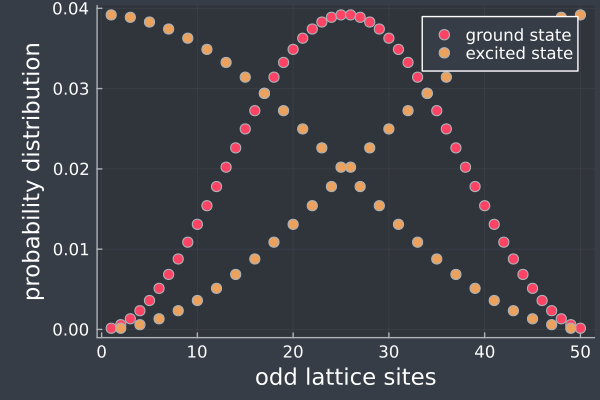

In [5]:
# get basis, Hamiltonian and eigenvectors.
numSites = 50
basis = fermions.BasisStates(numSites, 1)
hamiltonian = TightBindHamiltonian(numSites)
eigvals, eigvecs = fermions.Spectrum(hamiltonian, basis)

# Define the local density operator, which is just the number operator n_i at a site i. 
# Within the fermions.jl library, the number operator is represented using "n", just as c
# and c^† are represented using "-" and "+".
densityOperators = [[("n", [i], 1.0)] for i in 1:numSites]

# calculate the expectation value of the local density operator in the ground state 
# and a mid-spectrum state. the expectation value is calculated using an internal 
# function GenCorrelation(state, operator), which returns the quantity <state|operator|state>.
distribution_low = [fermions.GenCorrelation(eigvecs[1], operator) for operator in densityOperators]
distribution_mid = [fermions.GenCorrelation(eigvecs[div(numSites, 2)], operator) for operator in densityOperators]

Plots.scatter([distribution_low, distribution_mid], thickness_scaling=1.4, linewidth=3, legend=true,
        xlabel="odd lattice sites", ylabel="probability distribution", labels=["ground state" "excited state"], margin=-1mm)

# Real-space Entanglement
---
As a second demonstration of the physics, we calculate the entanglement entropy of real space regions. Entanglement entropy is a measure of entanglement, quantifying how much a region of space is "connected" to the other regions. The source of the connection is the presence of the hopping term in the hamiltonian; as the electron hops from one end of the system to the other, it carries information with it, leading to non-local connections between distant regions. `fermions.jl` provides several functions to calculate various entanglement measures such as the von Neumann entropy (`vnEntropy()`), mutual information (`mutInfo`) and tripartite information (`tripInfo`). For this model, we will just calculate the von Neumann entropy of any given lattice site $i$, through the function call `vnEntropy(state, [i])`, where `state` is as usual the ground state, and `[i]` indicates the set of indices whose entanglement entropy will be calculated. Since we want to calculate the entropy of just the $i^\mathrm{th}$ site, the indices is a singleton set for us. 

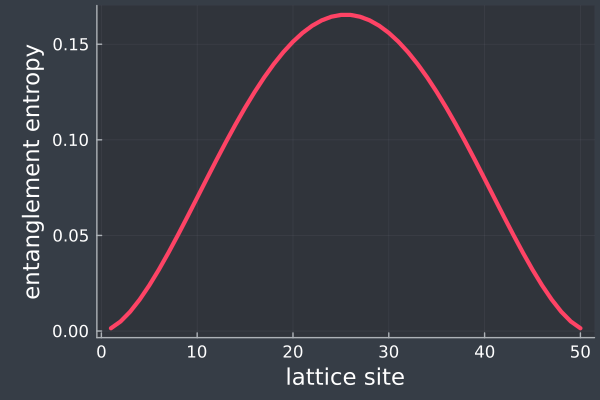

In [6]:
# define regions of space of increasing size
subsystemIndices = [[i] for i in 1:numSites]

# calculate entanglement entropy of these regions
SEE = [fermions.vnEntropy(eigvecs[1], indices) for indices in subsystemIndices]
Plots.plot(SEE, thickness_scaling=1.4, linewidth=3, legend=false,
        xlabel="lattice site", ylabel="entanglement entropy", margin=-1mm)

# Finite Temperature Calculations: Local Probability Distribution as a Function of Temperature
---
One can also calculate thermal averages using the library. Similar to the `GenCorrelation` function that computes expectation values in a particular state, the `ThermalAverage(eigvecs, eigvals, operator, beta)` function accepts the complete set of eigenvectors $\{X_i\}$ and eigenvalues $\{\varepsilon_i\}$, an operator $\hat O$ and an inverse temperature beta $\beta$, and calculates the thermal expectation value $\sum_i e^{-\beta E_i}\langle X_i | \hat O | X_i \rangle$. In the snippet below, we compute the thermal average of two operators, the probability of occupying the left edge $\hat n_1$, and the probability of occupying the central site $\hat n_{N/2}$.

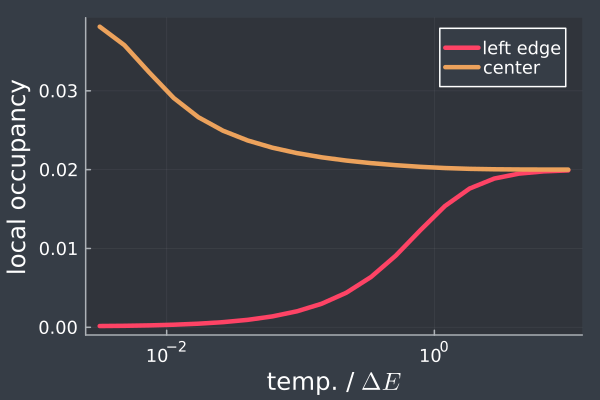

In [7]:
# define a range of temperatures to perform calculations at
invTempRange = 10 .^ range(-1, 2.5, 20)

# define the operators whose thermal average we wish to calculate
leftOccOperator = [("n", [1], 1.0)] # occupancy of left edge
centerOccOperator = [("n", [div(numSites, 2)], 1.0)] # occupancy of center

# calculate thermal averages over the given range of inverse temperature
leftOccAverage = [fermions.ThermalAverage(eigvecs, eigvals, leftOccOperator, beta) for beta in invTempRange]
centerOccAverage = [fermions.ThermalAverage(eigvecs, eigvals, centerOccOperator, beta) for beta in invTempRange]

Plots.plot(1 ./ invTempRange, [leftOccAverage, centerOccAverage];
    thickness_scaling=1.5, linewidth=3,
    xaxis=:log10, xlabel="temp. / \$\\Delta E\$", ylabel="local occupancy", 
    labels=["left edge" "center"], leftmargin=-5mm, bottommargin=-3mm)

# Spectral Function
---
As a final demonstration, we show how to calculate the local spectral function for the model. A spectral function $A(\omega)$ captures the probability of exciting the ground state of a system into an excited electron with a particular excitation energy $\omega$; a higher value of the spectral function at a particular frequency indicates a higher likelihood of exciting the system by shedding light of that frequency. Formally, the spectral function associated with the excitation operator $\hat O_1$ and the relaxation operator $\hat O_2$ is defined as 
$$
A(\omega) = -\frac{1}{\pi}\mathrm{Im}\left[\mathcal{F}_\omega(\langle \Psi_\mathrm{gs}\{\hat O_2(t),\hat O_1(0)\}\Psi_\mathrm{gs}\rangle)\right]~,
$$
where $\mathcal{F}_\omega(\cdot)$ is the Fourier transform.

The spectral function is calculated using the provided function `SpecFunc(eigvecs, eigvals, probe, probeDag, freqArr, broadening)`, where `eigvecs, eigvals` constitute the spectrum of the system, `probe` and `probeDag` are the excitation and relaxation operators $\hat O_1$ and $\hat O_2$, `freqArr` is the set of frequency points at which the spectral function must be calculated, and `broadening` is the width of the Lorentzian that will be used to replace poles. For the snippet below, we have taken the local operators $c_{N/2}$ and $c^\dagger_{N/2}$ as the excitation and relaxation operators.

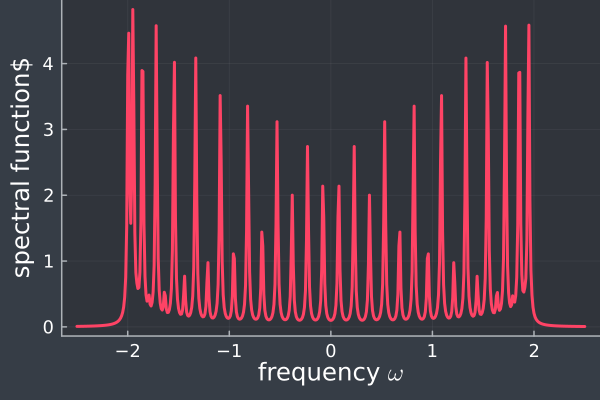

In [8]:
numSites = 40 # number of lattice sites

# Get basis states for a system with 0, 1 and 2 occupied sites.
# The ground state will be taken from the 1 occupied site system,
# but the excitations will take it to the other systems.
basis_N = fermions.BasisStates(numSites, 1)
basis_Nminus1 = fermions.BasisStates(numSites, 0)
basis_Nplus1 = fermions.BasisStates(numSites, 2)

# diagonalise all three systems
tightBindHam = TightBindHamiltonian(numSites)
eigvals_N, eigvecs_N = fermions.Spectrum(tightBindHam, basis_N)
eigvals_Nminus1, eigvecs_Nminus1 = fermions.Spectrum(tightBindHam, basis_Nminus1)
eigvals_Nplus1, eigvecs_Nplus1 = fermions.Spectrum(tightBindHam, basis_Nplus1)

# define the set of frequency points
freqArr = collect(range(-2.5, stop=2.5, step=0.01))

# define the excitation and relaxation operators
probe = [("-", [div(numSites, 2)], 1.0)]
probeDag = [("+", [div(numSites, 2)], 1.0)]

# get spectral function
specfunc = fermions.SpecFunc([eigvals_N; eigvals_Nminus1; eigvals_Nplus1], 
    [eigvecs_N; eigvecs_Nminus1; eigvecs_Nplus1], probe, probeDag, freqArr, 1e-2)

p = Plots.plot(freqArr, specfunc, thickness_scaling=1.5, linewidth=2, legend=false, 
    xlabel="frequency \$\\omega\$", ylabel="spectral function\$", margin=-2mm)
display(p)